In [2]:
from glob import glob
import statistics
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
import re
# import numpy as np

### Make getorf candidates for each protein based on reference protein length distribution

In [3]:
filenames = glob('data/refs_tobamo/*')
getorf = pd.read_csv('data/getorf_stats.csv')
results = pd.read_csv('/home/tobamo/analize/project-tobamo/results/megan6_results_combined_add_nr_taxa.csv')
getorf_path = 'data/getorf_output.fasta'
getorf_path_find1 = 'results/getorf_output_find1_270.fasta'

In [4]:
ref_stats = {}
proteins = []

for file in filenames:
    name = file.split('/')[-1].split('.')[0]
    with open(file, 'r') as fin:
        fasta_lens = sorted([len(r.seq) for r in SeqIO.parse(fin, 'fasta')])
        minlen = min(fasta_lens)
        maxlen = max(fasta_lens)
        med = round(statistics.median(fasta_lens), 2)
        mean = round(statistics.mean(fasta_lens), 2)
        sd = round(statistics.stdev(fasta_lens),2)
    proteins.append(name)
    
    ref_stats[name] = {'min':minlen, 'max':maxlen, 'median': med, 'mean': mean, 'stdev':sd, 'lens':fasta_lens}
    

In [5]:
ref_stats_df = pd.DataFrame(ref_stats).T
# remove outlyer Gorica orf1 len 773
ref_stats_df.loc['rdrp_orf1', 'lens'] = ref_stats_df.loc['rdrp_orf1', 'lens'][1:]
ref_stats_df

,min,max,median,mean,stdev,lens
cp,124,208,159,160.74,10.39,"[124, 134, 157, 157, 157, 157, 157, 157, 157, ..."
rdrp_orf2,311,501,471.0,463.94,38.64,"[311, 312, 393, 403, 417, 434, 435, 444, 445, ..."
mp,216,334,267.0,272.81,21.01,"[216, 219, 254, 256, 256, 256, 256, 257, 258, ..."
rdrp_orf1,773,1166,1116,1115.04,52.81,"[1081, 1097, 1100, 1100, 1103, 1103, 1103, 110..."


In [6]:
tax_info = results[['qseqid', 'megan_tax']].drop_duplicates()

Check long ORFs

In [10]:
long_orfs = getorf[getorf['seq_len'] > 1700]
long_taxa = long_orfs.merge(tax_info, how='left', left_on='contig', right_on='qseqid').drop(columns=['qseqid'])

In [13]:
long_df = pd.DataFrame(long_taxa.megan_tax.value_counts())
long_df.to_excel('long_df.xlsx')

Check potential Whole RDRPs

In [21]:
potential_whole_rdrps = getorf[(getorf['seq_len'] > 1117) & (getorf['seq_len'] < 1700)]

In [30]:
potential_whole_rdrp_orfs = list(potential_whole_rdrps.orf_name)

In [31]:
fasta_out = 'results/potential_whole_rdrps.fasta'

# make new filtered fasta
with open(getorf_path, "r") as file, open(fasta_out, "w") as outfile:
    out_seq = (r for r in SeqIO.parse(file, "fasta") if r.id in potential_whole_rdrp_orfs)
    SeqIO.write(out_seq, outfile, "fasta")

One SRR produces a huge amount of contigs and consequently a lot of ORFs

In [23]:
x = getorf[getorf['SRR'] == 'SRR6846476']
x.contig.nunique()

1649

In [10]:
# SRR6846476 - 3198 ORFs (suspicious)
getorf.groupby('SRR').size().sort_values(ascending=False).head(2)

SRR
SRR6846476    3198
SRR1781945      99
dtype: int64

GETORF -find 0 -minsize 270

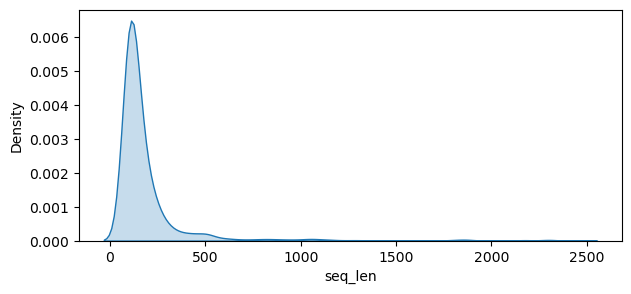

In [13]:
fig, ax = plt.subplots(figsize=(7,3))
fig = sns.kdeplot(getorf.seq_len, fill=True)

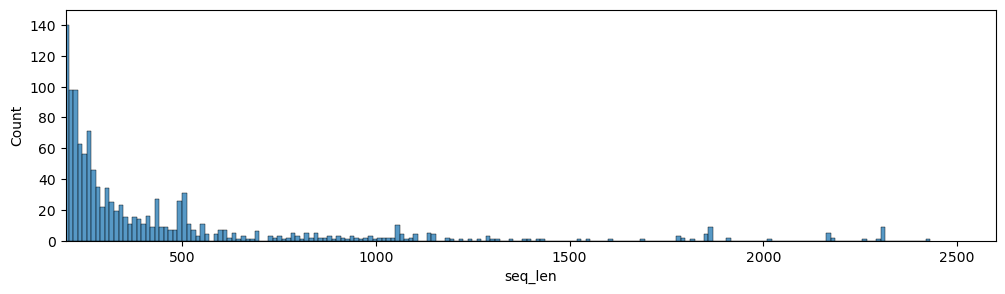

In [12]:
fig, ax = plt.subplots(figsize=(12,3))

sns.histplot(data=getorf, x='seq_len', bins=200)
plt.xlim(200,2600)
plt.ylim(0,150)
plt.show()

Number of ORFs vs. Contig length

In [14]:
# Regular expression pattern to extract length or len
pattern = r'(?:length|len)_(\d+)'

# Function to extract length
def extract_length(text):
    match = re.search(pattern, text)
    if match:
        return int(match.group(1))
    else:
        return None

# Create new column 'Length' by applying the function to the 'ID' column
getorf['contig_length'] = getorf['contig'].apply(extract_length)

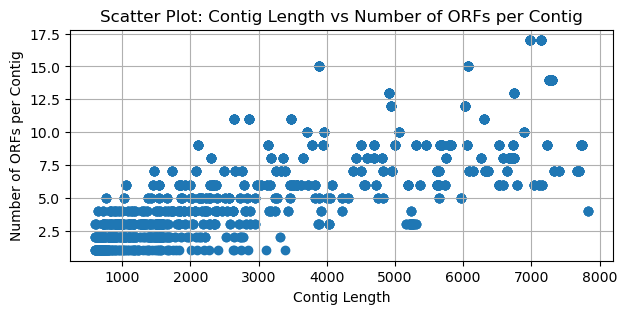

In [15]:
df = getorf
orf_counts = df.groupby('contig').size()

fig, ax = plt.subplots(figsize=(7,3))
plt.scatter(df['contig_length'], df['contig'].map(orf_counts))
plt.xlabel('Contig Length')
plt.ylabel('Number of ORFs per Contig')
plt.title('Scatter Plot: Contig Length vs Number of ORFs per Contig')
plt.grid(True)
plt.show()

#### Filter getorf fasta based on orf len

compare FIND1 and FIND0

In [17]:
getorf_path_find0 = 'data/getorf_output.fasta'
getorf_path_find1 = 'results/getorf_output_find1_270.fasta'

In [18]:
def parse_fasta_to_df(fasta_file):
    sequences = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences.append((record.id, str(record.seq)))

    df = pd.DataFrame(sequences, columns=["orf_name", "seq"])

    def remove_last_number(s):
        return re.sub(r"_(\d+)$", "", s)

    df['contig'] = df['orf_name'].apply(lambda x: remove_last_number(x))
    df["SRR"] = df["contig"].str.extract(r"_([A-Za-z0-9]+)$")
    df['seq_len'] = df['seq'].apply(len)

    columns = ['SRR', 'contig', 'orf_name', 'seq', 'seq_len']
    df = df[columns]
    return df

In [19]:
getorf0 = parse_fasta_to_df(getorf_path_find0)
getorf1 = parse_fasta_to_df(getorf_path_find1)

In [20]:
getorf1 = getorf1.rename(columns={'seq_len':'getorf1_seq_len'})
getorf0 = getorf0.rename(columns={'seq_len':'getorf0_seq_len'})

GETORF FIND 1 minsize = 360, maxsize = 3510

In [23]:
getorf_270_3510 = parse_fasta_to_df('/home/tobamo/analize/project-tobamo/analysis/whole_orf/results/getorf_output_find1_min_360_max_3510.fasta')
getorf_270_3510_tobamo = parse_fasta_to_df('/home/tobamo/analize/project-tobamo/analysis/whole_orf/results/getorf_output_find1_min_360_max_3510_reference_tobamo.fasta')

SANITY CHECK  - tobamo reference getorf output

Text(0.5, 1.0, 'Tobamo reference genome GETORF results')

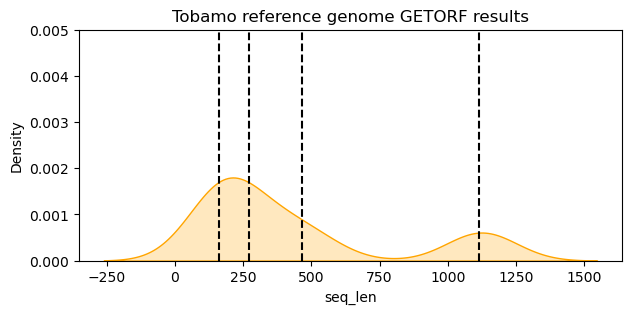

In [24]:
fig, ax = plt.subplots(figsize=(7,3))
fig = sns.kdeplot(getorf_270_3510_tobamo.seq_len, fill=True, color='orange')

# Add vertical lines
vertical_lines = [1115.04, 272.81, 463.94, 160.74]  # List of x-values for vertical lines
for x in vertical_lines:
    ax.axvline(x=x, color='black', linestyle='--')

ax.set_ylim(0, 0.005)
ax.set_title('Tobamo reference genome GETORF results')

Text(0.5, 1.0, 'number of ORFs per reference genome')

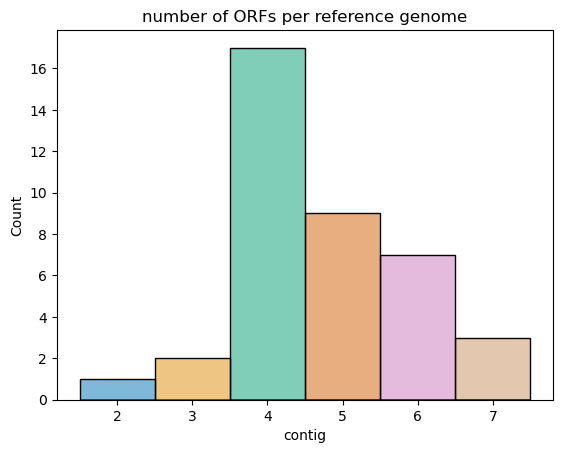

In [25]:
contig_value_counts = getorf_270_3510_tobamo['contig'].value_counts()

fig = sns.histplot(x=contig_value_counts, discrete=True, hue = contig_value_counts, palette = 'colorblind', legend=False)
fig.set_title('number of ORFs per reference genome')

In [27]:
df = getorf_270_3510

ranges = {
    "cp": (124, 208),
    "rdrp_orf2": (311, 501),
    "mp": (216, 334),
    "rdrp_orf1": (1081, 1166)
}

expanded_ranges = {col: (min_val - 10, max_val + 10) for col, (min_val, max_val) in ranges.items()}

masks = {
    col: (df["seq_len"] >= min_val) & (df["seq_len"] <= max_val)
    for col, (min_val, max_val) in expanded_ranges.items()
}

combined_mask = pd.concat(masks, axis=1).any(axis=1)

filtered_df = df[combined_mask]

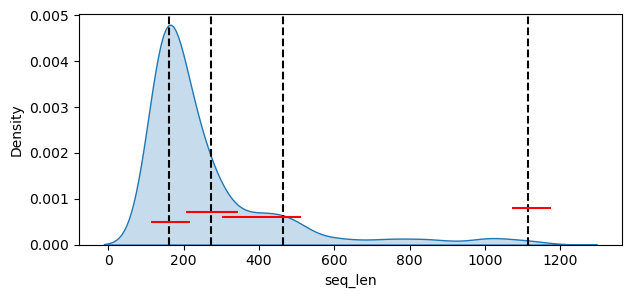

In [28]:
fig, ax = plt.subplots(figsize=(7,3))
fig = sns.kdeplot(getorf_270_3510.seq_len, fill=True)

# Add vertical lines
vertical_lines = [1115.04, 272.81, 463.94, 160.74]  # List of x-values for vertical lines
for x in vertical_lines:
    ax.axvline(x=x, color='black', linestyle='--')
y = 0.0005
# Add horizontal lines
for val in expanded_ranges.values():
    plt.hlines(y=y, color='red', xmin = val[0], xmax=val[1])
    y += 0.0001

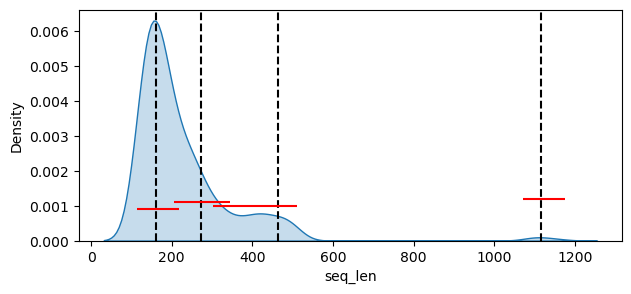

In [29]:
fig, ax = plt.subplots(figsize=(7,3))
fig = sns.kdeplot(filtered_df.seq_len, fill=True)

# Add vertical lines
vertical_lines = [1115.04, 272.81, 463.94, 160.74]  # List of x-values for vertical lines
for x in vertical_lines:
    ax.axvline(x=x, color='black', linestyle='--')

# Add horizontal lines
for val in expanded_ranges.values():
    plt.hlines(y=y, color='red', xmin = val[0], xmax=val[1])
    y += 0.0001

In [30]:
for protein in proteins:
    fasta_out = f"results/getorf_candidates/getorf_{protein}_candidates.fasta"
    min_lim, max_lim = ranges[protein]
    min_lim -= 10
    max_lim += 10
    
    print(min_lim,max_lim)
    # make new filtered fasta
    with open(getorf_path, "r") as file, open(fasta_out, "w") as outfile:
        out_seq = (r for r in SeqIO.parse(file, "fasta") if min_lim < len(r.seq) < max_lim)
        SeqIO.write(out_seq, outfile, "fasta")

114 218
301 511
206 344
1071 1176
